In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.preprocessing import QuantileTransformer

from sklearn import preprocessing

import sys
!{sys.executable} -m pip install catboost

import sys
sys.path.append('/Users/o.antonov/.local/lib/python3.8/site-packages')

In [2]:
from catboost import *

In [3]:
data = pd.read_csv('used_cars/train.csv')

In [4]:
data.loc[data['year'] > pd.to_datetime(data['saledate'], utc = True).dt.year, 'year'] = \
        pd.to_datetime(data['saledate'], utc = True).dt.year

In [5]:
data.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

<AxesSubplot:>

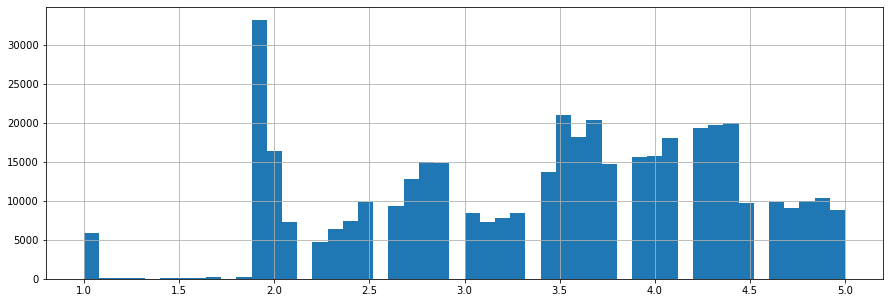

In [6]:
data['condition'].hist(figsize = (15,5), bins = 50)

<AxesSubplot:>

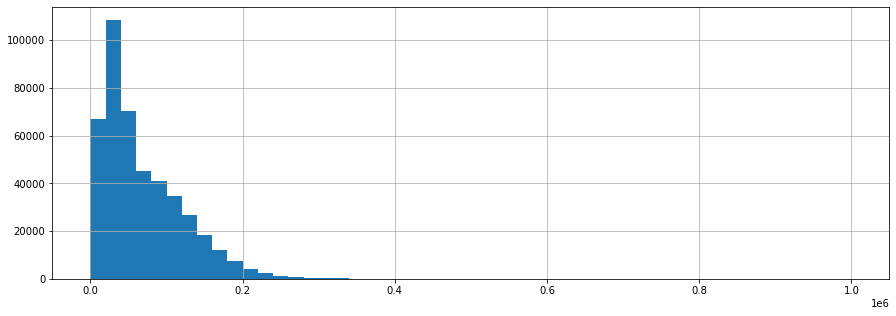

In [7]:
data['odometer'].hist(figsize = (15,5), bins = 50)

In [8]:
data['odometer'].mode()

0    1.0
dtype: float64

In [9]:
condition_imputer = IterativeImputer()

data[['condition']] = condition_imputer.fit_transform(data[['condition']] )

<AxesSubplot:>

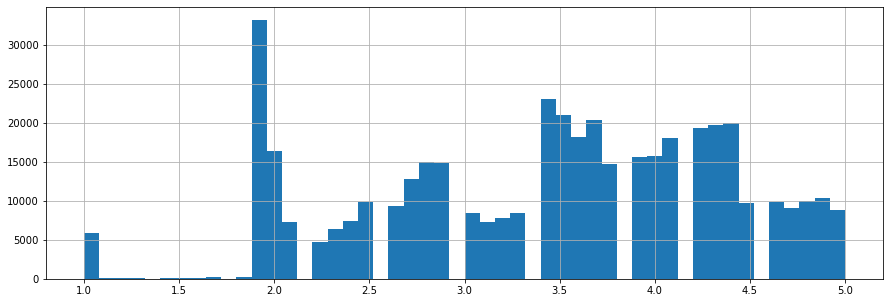

In [10]:
data['condition'].hist(figsize = (15,5), bins = 50)

<AxesSubplot:>

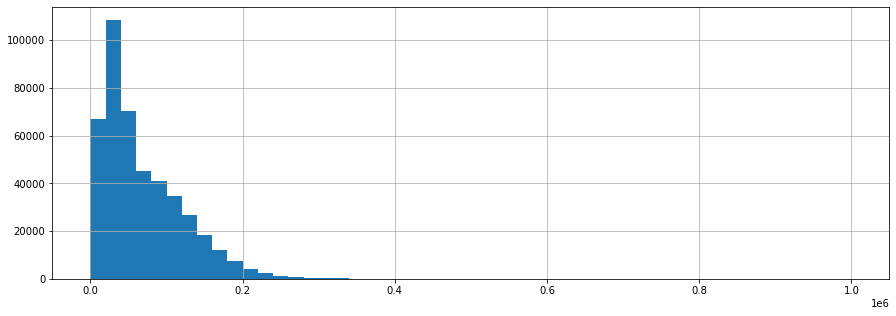

In [11]:
data['odometer'].hist(figsize = (15,5), bins = 50)

In [12]:
simple_imputer = SimpleImputer(strategy="most_frequent")


    df1 = data.groupby(['model', 'transmission'])['year'].count().reset_index()
    df2 = df1.groupby('model')['year'].max().reset_index()
    df3 = df1.merge(df2, on = 'model')
    df_fin = df3[df3['year_x']== df3['year_y']][['model', 'transmission']]
    df_fin.columns = ['model', 'transmission_fill']
    df_fin = df_fin.groupby('model')['transmission_fill'].min().reset_index()
    data = data.merge(df_fin, on = 'model', how = 'left')
    data.loc[data['transmission'].isna(), 'transmission'] = data.loc[data['transmission'].isna(), 'transmission_fill']
    data.drop('transmission_fill', axis = 1, inplace = True)

In [13]:
data['body'].str.lower().str.contains("coupe")

0         False
1         False
2         False
3         False
4         False
          ...  
440231    False
440232    False
440233     True
440234    False
440235    False
Name: body, Length: 440236, dtype: object

In [14]:
data['odometer'].median()

52098.0

In [15]:
def data_preprocessing(data):

#    data.loc[data['transmission'].isna(), 'transmission'] = 'automatic'
    for c in ['make','model','trim','seller', 'body']:
        data[c] = data[c].str.lower()#.fillna('no info')
    map_dict = {
            'dodge tk':'dodge', 
            'ford truck':'ford', 
            'gmc truck':'gmc', 
            'landrover':'land rover', 
            'mazda tk':'mazda',
            'mercedes':'mercedes-benz',
            'mercedes-b' : 'mercedes-benz',
            'vw':'volkswagen'
           }
    data['make'] = data['make'].replace(map_dict)

    
#    for c in ['model', 'trim', 'seller']:
#        l = sum(data[c].value_counts()>10)
#        top_model = data[c].value_counts().head(l).index.to_numpy()
#        data[c] = data[c].apply(lambda x: x if x in top_model else 'other')
    data['interior'] = data['interior'].str.replace('—', 'no info').fillna('no info')
    data['color'] = data['color'].str.replace('—','no info').fillna('no info')

    data['saledate'] = pd.to_datetime(data['saledate'], utc = True)
    data.loc[data['condition'].isna(), 'condition'] = data['condition'].mode()[0]
    data.loc[data['odometer'].isna(), 'odometer'] = data['odometer'].mode()[0]

    data['odometer_log'] = (data['odometer']+1).transform(np.log)
    
    data['saleyear'] = data['saledate'].dt.year
    data['age'] =  data['saleyear'] - data['year'] + 1
    data['salemonth'] = data['saledate'].dt.month
    data['salemonth_new'] = data['salemonth'].astype(str)+data['saleyear'].astype(str)
    data = data.drop(['saledate'], axis = 1)
    data['body'] = data['body'].str.lower()
    data.loc[(data['body'].str.contains("coupe"))&(~data['body'].isna()), 'body'] = 'coupe'
    data.loc[(data['body'].str.contains("cab"))&(~data['body'].isna()), 'body'] = 'cab'
    data.loc[(data['body'].str.contains("wagon"))&(~data['body'].isna()), 'body'] = 'wagon'
    data.loc[(data['body'].str.contains("convertible"))&(~data['body'].isna()), 'body'] = 'convertible'
    data.loc[(data['body'].str.contains("van"))&(~data['body'].isna()), 'body'] = 'van'
    data.loc[(data['body'].str.contains("sedan"))&(~data['body'].isna()), 'body'] = 'sedan'
    data.loc[(data['body'].str.contains("supercrew"))&(~data['body'].isna()), 'body'] = 'cab'
    data.loc[(data['body'].str.contains("koup"))&(~data['body'].isna()), 'body'] = 'coupe'
    return data

In [16]:
data = data_preprocessing(data)

data['odometer_log'].hist(figsize = (15,5), bins = 50)

data.loc[data['odometer_log']<data['odometer_log'].quantile(0.01), 'odometer_log'] =\
        data['odometer_log'].quantile(0.01)

data.loc[data['odometer_log']>data['odometer_log'].quantile(0.99), 'odometer_log'] =\
        data['odometer_log'].quantile(0.99)

data['odometer_log'].hist(figsize = (15,5), bins = 50)

In [17]:
trans = preprocessing.QuantileTransformer(output_distribution='normal', random_state=12345)
data[['age_norm', 'condition_norm', 'odometer_norm']] = trans.fit_transform(data[['age', 'condition', 'odometer']])

In [18]:
data[['transmission', 'body', 'make']] = \
        simple_imputer.fit_transform(data[['transmission', 'body', 'make']])

In [19]:
data[['model','trim','seller']] = data[['model','trim','seller']].fillna('no info')

In [20]:
data.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'odometer_log', 'saleyear', 'age', 'salemonth', 'salemonth_new',
       'age_norm', 'condition_norm', 'odometer_norm'],
      dtype='object')

In [21]:
cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

In [22]:
X = data.drop(['sellingprice','vin'], axis = 1)
y = data['sellingprice']

In [683]:
X.isna().sum()

year              0
make              0
model             0
trim              0
body              0
transmission      0
state             0
condition         0
odometer          0
color             0
interior          0
seller            0
odometer_log      0
saleyear          0
age               0
salemonth         0
salemonth_new     0
age_norm          0
condition_norm    0
odometer_norm     0
dtype: int64

In [575]:
%time
# Create a CatBoost regressor object
catboost = CatBoostRegressor()

# Define the hyperparameters to tune
parameters = {'iterations': [1600, 1900],
              'depth': [13],
              'one_hot_max_size':[30],
              'l2_leaf_reg': sp_randInt(2,10),
              'learning_rate':sp_randFloat(0.05,0.15),
              'random_strength':sp_randFloat(0,6)
             }

# Create a GridSearchCV object
rand_search = RandomizedSearchCV(catboost, parameters, cv=2, \
                                 scoring='neg_mean_absolute_percentage_error', n_iter = 16, n_jobs = -1, verbose = 100)

# Fit the GridSearchCV object to the data
rand_search.fit(X, y, cat_features=cat_features)

# Print the best parameters and score
print("Best parameters:", rand_search.best_params_)
print("Best score:", rand_search.best_score_)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 12.9 µs
Fitting 2 folds for each of 16 candidates, totalling 32 fits


KeyboardInterrupt: 

In [ ]:
model = rand_search.best_estimator_

In [ ]:
# Create a CatBoost regressor object
catboost = CatBoostRegressor()

# Define the hyperparameters to tune
parameters = {'iterations': [1600, 1900],
              'loss_function':['RMSE'],
              'learning_rate': [0.086],
              'one_hot_max_size': [30],
              'l2_leaf_reg' : [5,7,9]
              'depth': [13],
              'verbose':[100]
             }

# Create a GridSearchCV object
grid_search = GridSearchCV(catboost, parameters, cv=3, scoring='neg_mean_absolute_percentage_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X, y, cat_features=cat_features)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Лучший результат -0.1705

In [ ]:
model = grid_search.best_estimator_

### гридсерч катбуста

In [23]:
model = CatBoostRegressor(loss_function='RMSE', eval_metric = 'MAPE', cat_features=cat_features)
grid_search_res = model.grid_search({'iterations': [1200],
              'learning_rate': [0.1],
              'one_hot_max_size': [60],
              'l2_leaf_reg' : [6],
             'random_strength':[3.0],
              'depth': [12,13,14],
              'verbose':[100],
             
             }
,
            X,
            y,
            cv=3,
            partition_random_seed=42,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            plot=False,
)

print(grid_search_res)

0:	learn: 0.8754099	test: 0.8715387	best: 0.8715387 (0)	total: 228ms	remaining: 4m 33s
100:	learn: 0.2555531	test: 0.2152851	best: 0.2152716 (99)	total: 14.4s	remaining: 2m 36s
200:	learn: 0.2251704	test: 0.1932601	best: 0.1932601 (200)	total: 27.2s	remaining: 2m 15s
300:	learn: 0.2046184	test: 0.1795289	best: 0.1795289 (300)	total: 42.6s	remaining: 2m 7s
400:	learn: 0.1918120	test: 0.1717378	best: 0.1717378 (400)	total: 54.1s	remaining: 1m 47s
500:	learn: 0.1829795	test: 0.1668037	best: 0.1667877 (498)	total: 1m 6s	remaining: 1m 32s
600:	learn: 0.1768564	test: 0.1624331	best: 0.1624331 (600)	total: 1m 17s	remaining: 1m 16s
700:	learn: 0.1687797	test: 0.1594462	best: 0.1594335 (698)	total: 1m 28s	remaining: 1m 2s
800:	learn: 0.1634230	test: 0.1568622	best: 0.1568622 (800)	total: 1m 40s	remaining: 50s
900:	learn: 0.1590642	test: 0.1551079	best: 0.1551079 (900)	total: 1m 51s	remaining: 37.2s
1000:	learn: 0.1560121	test: 0.1536682	best: 0.1536682 (1000)	total: 2m 3s	remaining: 24.5s
1100:

In [ ]:
grid_search_res

In [124]:
# Create a CatBoost regressor object
catboost = CatBoostRegressor()

# Define the hyperparameters to tune
parameters = {'iterations': [1600, 1900],
              'learning_rate': [0.086],
              'one_hot_max_size': [30, 60],
              'l2_leaf_reg' : [5,7,9],
             'random_strength':[3.4],
              'depth': [13],
              'verbose':[100]
             }

# Create a GridSearchCV object
grid_search = GridSearchCV(catboost, parameters, cv=3, scoring='neg_mean_absolute_percentage_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X, y, cat_features=cat_features)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

0:	learn: 9198.5117594	total: 819ms	remaining: 21m 49s
100:	learn: 2680.0961684	total: 16.7s	remaining: 4m 8s
200:	learn: 2249.8194866	total: 31.5s	remaining: 3m 39s
300:	learn: 2017.8622405	total: 45s	remaining: 3m 14s
400:	learn: 1860.6780870	total: 59.7s	remaining: 2m 58s
500:	learn: 1741.6965578	total: 1m 13s	remaining: 2m 41s
600:	learn: 1656.4790947	total: 1m 27s	remaining: 2m 25s
700:	learn: 1579.6037795	total: 1m 42s	remaining: 2m 10s
800:	learn: 1508.8968280	total: 1m 56s	remaining: 1m 55s
900:	learn: 1442.6502461	total: 2m 10s	remaining: 1m 41s
1000:	learn: 1381.8491687	total: 2m 24s	remaining: 1m 26s
1100:	learn: 1333.2729236	total: 2m 38s	remaining: 1m 11s
1200:	learn: 1283.5038169	total: 2m 52s	remaining: 57.4s
1300:	learn: 1239.9978509	total: 3m 7s	remaining: 43s
1400:	learn: 1198.9438830	total: 3m 21s	remaining: 28.6s
1500:	learn: 1158.1222659	total: 3m 36s	remaining: 14.3s
1599:	learn: 1123.2998338	total: 3m 50s	remaining: 0us
0:	learn: 9117.8440102	total: 218ms	remaini

900:	learn: 1454.9936567	total: 7m 10s	remaining: 5m 33s
1000:	learn: 1398.7314807	total: 7m 53s	remaining: 4m 43s
1100:	learn: 1348.3583145	total: 8m 35s	remaining: 3m 53s
1200:	learn: 1300.4537066	total: 9m 15s	remaining: 3m 4s
1300:	learn: 1261.2892603	total: 9m 56s	remaining: 2m 17s
1400:	learn: 1224.9842170	total: 10m 38s	remaining: 1m 30s
1500:	learn: 1192.3224314	total: 11m 21s	remaining: 44.9s
1599:	learn: 1161.0458354	total: 12m	remaining: 0us
0:	learn: 9200.1345020	total: 365ms	remaining: 9m 44s
100:	learn: 2945.6062565	total: 25s	remaining: 6m 11s
200:	learn: 2577.3250742	total: 48.3s	remaining: 5m 36s
300:	learn: 2327.7829421	total: 1m 12s	remaining: 5m 12s
400:	learn: 2160.2309275	total: 1m 36s	remaining: 4m 49s
500:	learn: 2045.5308482	total: 2m 2s	remaining: 4m 27s
600:	learn: 1948.4954759	total: 2m 25s	remaining: 4m 2s
700:	learn: 1870.5244875	total: 2m 50s	remaining: 3m 38s
800:	learn: 1796.5103943	total: 3m 15s	remaining: 3m 14s
900:	learn: 1728.9797814	total: 3m 38s	

200:	learn: 2507.2484420	total: 45.9s	remaining: 5m 19s
300:	learn: 2267.4675850	total: 1m 9s	remaining: 5m 1s
400:	learn: 2113.4422731	total: 1m 32s	remaining: 4m 36s
500:	learn: 1999.7512642	total: 1m 55s	remaining: 4m 12s
600:	learn: 1906.5597861	total: 2m 18s	remaining: 3m 49s
700:	learn: 1827.5892385	total: 2m 40s	remaining: 3m 25s
800:	learn: 1761.2981022	total: 3m 3s	remaining: 3m 2s
900:	learn: 1703.1754452	total: 3m 25s	remaining: 2m 39s
1000:	learn: 1651.2276109	total: 3m 47s	remaining: 2m 16s
1100:	learn: 1605.7892008	total: 4m 8s	remaining: 1m 52s
1200:	learn: 1565.8647957	total: 4m 31s	remaining: 1m 30s
1300:	learn: 1530.0788961	total: 4m 52s	remaining: 1m 7s
1400:	learn: 1490.4847646	total: 5m 13s	remaining: 44.6s
1500:	learn: 1456.7646873	total: 5m 35s	remaining: 22.2s
1599:	learn: 1422.9474716	total: 5m 56s	remaining: 0us
0:	learn: 9198.5117594	total: 319ms	remaining: 10m 5s
100:	learn: 2680.0961684	total: 30.9s	remaining: 9m 10s
200:	learn: 2249.8194866	total: 1m 2s	re

1000:	learn: 1467.4679982	total: 5m 11s	remaining: 4m 39s
1100:	learn: 1415.1784208	total: 5m 42s	remaining: 4m 8s
1200:	learn: 1365.7570838	total: 6m 14s	remaining: 3m 37s
1300:	learn: 1318.6954518	total: 6m 47s	remaining: 3m 7s
1400:	learn: 1277.3182770	total: 7m 20s	remaining: 2m 36s
1500:	learn: 1239.3674936	total: 7m 54s	remaining: 2m 6s
1600:	learn: 1205.4033387	total: 8m 27s	remaining: 1m 34s
1700:	learn: 1171.0922053	total: 9m 1s	remaining: 1m 3s
1800:	learn: 1138.6271473	total: 9m 33s	remaining: 31.5s
1899:	learn: 1110.9456923	total: 10m 4s	remaining: 0us
0:	learn: 9119.5992183	total: 327ms	remaining: 10m 20s
100:	learn: 2709.5937207	total: 29s	remaining: 8m 37s
200:	learn: 2264.3596965	total: 58.9s	remaining: 8m 17s
300:	learn: 2039.3661941	total: 1m 31s	remaining: 8m 3s
400:	learn: 1908.1883099	total: 2m 3s	remaining: 7m 40s
500:	learn: 1797.2899168	total: 2m 35s	remaining: 7m 13s
600:	learn: 1709.8777123	total: 3m 5s	remaining: 6m 41s
700:	learn: 1631.5776137	total: 3m 37s	

1500:	learn: 1293.1240903	total: 7m 58s	remaining: 2m 7s
1600:	learn: 1257.6947230	total: 8m 32s	remaining: 1m 35s
1700:	learn: 1223.1266133	total: 9m 5s	remaining: 1m 3s
1800:	learn: 1194.2320462	total: 9m 38s	remaining: 31.8s
1899:	learn: 1166.8525490	total: 10m 11s	remaining: 0us
0:	learn: 9163.4815973	total: 248ms	remaining: 7m 51s
100:	learn: 2701.3626997	total: 33.3s	remaining: 9m 52s
200:	learn: 2286.9552960	total: 1m 4s	remaining: 9m 3s
300:	learn: 2050.8275927	total: 1m 35s	remaining: 8m 27s
400:	learn: 1897.6817697	total: 2m 8s	remaining: 7m 59s
500:	learn: 1781.0745007	total: 2m 41s	remaining: 7m 30s
600:	learn: 1700.1900029	total: 3m 13s	remaining: 6m 58s
700:	learn: 1628.2496143	total: 3m 46s	remaining: 6m 26s
800:	learn: 1562.1455459	total: 4m 18s	remaining: 5m 55s
900:	learn: 1505.5069375	total: 4m 50s	remaining: 5m 22s
1000:	learn: 1453.6429692	total: 5m 22s	remaining: 4m 49s
1100:	learn: 1406.8040956	total: 5m 54s	remaining: 4m 16s
1200:	learn: 1365.3891203	total: 6m 2

In [125]:
grid_search_res


NameError: name 'grid_search_res' is not defined

In [23]:
model=CatBoostRegressor(iterations = 4900, depth = 13, use_best_model = True,
                        l2_leaf_reg = 7, 
                        random_strength = 3.4,
                        learning_rate = 0.1,
                        one_hot_max_size = 60,#60,

                        #bootstrap_type = 'MVS',
                        loss_function='RMSE', eval_metric = 'MAPE', cat_features=cat_features, random_seed = 42)

In [ ]:
cv_dataset = Pool(data=X, label=y, cat_features=cat_features)

# Define the cross-validation strategy
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Define a list to store the validation scores for each fold
val_scores = []

# Loop over each fold and train/validate the model
for train_idx, val_idx in kf.split(X):
    # Split the data into training and validation sets
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # Fit the model to the training data
    model.fit(X_train, y_train, eval_set = (X_val, y_val), cat_features=cat_features, verbose=100)
    
    # Evaluate the model on the validation data
    y_pred = model.predict(X_val)
    val_score = np.mean(np.abs((y_val - y_pred) / y_val))
    val_scores.append(val_score)

# Compute the average validation score across all folds
avg_val_score = np.mean(val_scores)

print(f"Average validation score: {avg_val_score:.4f}")

0:	learn: 1.7421756	test: 1.6535801	best: 1.6535801 (0)	total: 284ms	remaining: 23m 12s
100:	learn: 0.2415113	test: 0.2140280	best: 0.2140280 (100)	total: 12s	remaining: 9m 30s
200:	learn: 0.2092000	test: 0.1926043	best: 0.1926043 (200)	total: 23.5s	remaining: 9m 8s
300:	learn: 0.1881369	test: 0.1790276	best: 0.1790276 (300)	total: 35.3s	remaining: 9m
400:	learn: 0.1748566	test: 0.1710504	best: 0.1710504 (400)	total: 47.1s	remaining: 8m 48s
500:	learn: 0.1656659	test: 0.1655973	best: 0.1655973 (500)	total: 59s	remaining: 8m 38s
600:	learn: 0.1605468	test: 0.1626059	best: 0.1625948 (597)	total: 1m 10s	remaining: 8m 26s
700:	learn: 0.1550787	test: 0.1602028	best: 0.1602028 (700)	total: 1m 23s	remaining: 8m 17s
800:	learn: 0.1500423	test: 0.1581440	best: 0.1581392 (799)	total: 1m 35s	remaining: 8m 6s
900:	learn: 0.1472222	test: 0.1566991	best: 0.1566991 (900)	total: 1m 47s	remaining: 7m 58s
1000:	learn: 0.1420507	test: 0.1555777	best: 0.1555725 (999)	total: 2m	remaining: 7m 48s
1100:	lear

3800:	learn: 0.0831087	test: 0.1871675	best: 0.1862826 (2311)	total: 8m 19s	remaining: 2m 24s
3900:	learn: 0.0814140	test: 0.1866582	best: 0.1862826 (2311)	total: 8m 33s	remaining: 2m 11s
4000:	learn: 0.0798155	test: 0.1862707	best: 0.1861363 (3988)	total: 8m 45s	remaining: 1m 58s
4100:	learn: 0.0782345	test: 0.1862934	best: 0.1860484 (4068)	total: 8m 59s	remaining: 1m 45s
4200:	learn: 0.0767529	test: 0.1862421	best: 0.1860484 (4068)	total: 9m 11s	remaining: 1m 31s


In [688]:
model_1200 = model

0.1693 --убираем униформ распределение получаем 0.1694

Устанавливаем random strength 3.0 получаем 0.1684

Возвращаем np.log получаем 0.1675

Возвращаем нормальное распределение кондишна получаем 0.1715

Убираем нормальное распределение кондишна добавляем нормальное распределение года получаем 0.1701

Убираем интеллектуальное заполнение пропусков  и нормальное распределение года получаем 0,1672

Возвращаем model в most frequent - 0.1674. Удаляем модел из мост фриквента

убираем age. год делаем медианой 0.1689

Ждем результат на кросс валидации 0.1604 и ниже

Результат с заменой transmission и body на most frequent - 0.1503, 0.2041, 0.1561, Итого 0.1702

Возвращаем замену моделей и модификаций с кол-вом меньше 10 на other. Получаем на первой кросс валидации 0.1510

Убираем замену моделей и модификаций Получаем на первой кросс валидации 0.1499, 0.2012, 0.1599, итого 0.1700

Убираем body из замены на most frequent. 

Возвращаем body и make в замену на most frequent Получаем на кросс валидации 0.1499

<AxesSubplot:ylabel='col'>

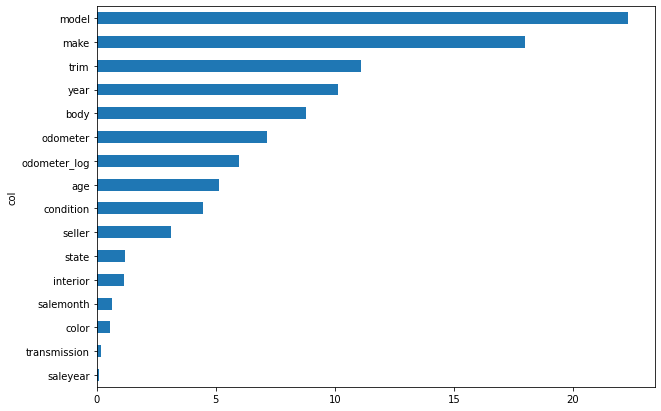

In [579]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)

In [42]:
test_data= pd.read_csv('used_cars/test.csv')

In [43]:
test_data.loc[test_data['year'] > pd.to_datetime(test_data['saledate'], utc = True).dt.year, 'year'] = \
        pd.to_datetime(test_data['saledate'], utc = True).dt.year

In [44]:
test_data['condition'] = condition_imputer.transform(test_data[['condition']])

In [45]:
X_test = data_preprocessing(test_data)

In [49]:
X_test[['age_norm', 'condition_norm', 'odometer_norm']] = \
    trans.transform(X_test[['age', 'condition', 'odometer']])

In [50]:
X_test[['transmission', 'body','make']] = \
        simple_imputer.transform(X_test[['transmission', 'body','make']])

In [51]:
X_test[['model','trim','seller']] = X_test[['model','trim','seller']].fillna('no info')

In [52]:
X_test.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'odometer_log',
       'saleyear', 'age', 'salemonth', 'salemonth_new', 'age_norm',
       'condition_norm', 'odometer_norm'],
      dtype='object')

In [53]:
X_test = X_test.drop(['vin'], axis = 1)
test_pool = Pool(X_test, cat_features=cat_features)
predicted = model.predict(test_pool)

In [54]:
predicted = pd.Series(predicted)

In [55]:
result = pd.concat([test_data['vin'], predicted], axis=1)

In [56]:
result.columns = ['vin', 'sellingprice']

In [57]:
result['vin'].isna().sum()

0

In [58]:
result.to_csv('result_submission21.csv', index = False)

In [51]:
test_data['saleyear']

2015    99357
2014    10703
Name: saleyear, dtype: int64

Найдем неявные дубликаты в качественных признаках

In [ ]:
data.columns

In [ ]:
for c in data.select_dtypes(include=['object']).columns:
    print(c, ': ',data[c].sort_values().unique())

Видим что некоторые марки дублируются. Приведем их к единому регистру

In [ ]:
data['make'] = data['make'].str.lower()

In [ ]:
data['make'].sort_values().unique()

In [ ]:
map_dict = {'dodge tk':'dodge', 
            'ford truck':'ford', 
            'gmc truck':'gmc', 
            'landrover':'land rover', 
            'mazda tk':'mazda',
            'mercedes':'mercedes-benz',
            'mercedes-b' : 'mercedes-benz',
            'vw':'volkswagen'
           }

In [ ]:
data['make'] = data['make'].replace(map_dict).fillna('no info')

In [ ]:
pd.options.display.max_rows = 100
data['make'].value_counts()

In [ ]:
data['saledate'].max()

In [ ]:
data['condition'].hist()

In [151]:
def data_preprocessing(data):
    for c in ['make','model','trim', 'body', 'transmission']:
        data[c] = data[c].str.lower().fillna('no info')
    map_dict = {
            'dodge tk':'dodge', 
            'ford truck':'ford', 
            'gmc truck':'gmc', 
            'landrover':'land rover', 
            'mazda tk':'mazda',
            'mercedes':'mercedes-benz',
            'mercedes-b' : 'mercedes-benz',
            'vw':'volkswagen'
           }
    data['make'] = data['make'].replace(map_dict).fillna('no info')
    for c in ['model', 'trim']:
        l = sum(data[c].value_counts()>10)
        top_model = data[c].value_counts().head(l).index.to_numpy()
        data[c] = data[c].apply(lambda x: x if x in top_model else 'other')
    data['interior'] = data['interior'].str.replace('-', 'no info').fillna('no info')
    data['color'] = data['color'].str.replace('-', 'no info').fillna('no info')
    
    data['saledate'] = pd.to_datetime(data['saledate'], utc = True)
    data.loc[data['condition'].isna(), 'condition'] = data['condition'].median()
    data.loc[data['odometer'].isna(), 'odometer'] = data['odometer'].median()
#    data['saleyear'] = data['saledate'].dt.year
#    data['salemonth'] = data['saledate'].dt.month
#    data = data.drop(['seller'], axis = 1)
    return data

In [ ]:
data = data_preprocessing(data)

In [ ]:
data.isna().sum()

In [ ]:
categorical_mask = (data.dtypes=='object')
categorical_columns = data.columns[categorical_mask].tolist()
oe_cols = [c for c in categorical_columns if data[c].nunique()>5]
ohe_cols = [c for c in categorical_columns if data[c].nunique()<=5]
len(oe_cols), len(ohe_cols)

In [ ]:
ohe_unique_list = [data[c].unique().tolist() for c in ohe_cols]
oe_unique_list = [data[c].unique().tolist() for c in oe_cols]
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore', categories=ohe_unique_list)
oe = OrdinalEncoder(handle_unknown = 'ignore', 
                    categories=oe_unique_list)



In [ ]:
preprocess = make_column_transformer(
    (oe, oe_cols),
    (ohe, ohe_cols),
    remainder='passthrough')

In [ ]:
pipeline = Pipeline([
    ('preprocess',preprocess),
    ('scale', StandardScaler())
    
])

In [ ]:
X = data.drop('sellingprice', axis = 1)
y = data['sellingprice']

In [ ]:
X = pipeline.fit_transform(X)

In [ ]:
model = RandomForestRegressor(random_state=12345) 
scores = cross_val_score(model, X, y, scoring = 'neg_mean_absolute_percentage_error', cv = 2) 
avg_mape = scores.sum()/len(scores) 
avg_mape

In [ ]:
from catboost import CatBoostRegressor
from catboost import Pool, cv
params = {"iterations": 100,
          "depth": 2,
          "loss_function": "MAPE",
          "verbose": False}
cv_dataset = Pool(data=X,
                  label=y)
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

model = RandomForestRegressor(random_state=12345)
scores = cross_val_score(model, X, y, scoring = 'neg_mean_absolute_percentage_error', cv = 5)
avg_mape = scores.sum()/len(scores)
avg_mape

In [ ]:
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X, y)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.cv_results_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

In [ ]:
model = grid_search.best_estimator_


In [ ]:
test_data = pd.read_csv('used_cars/test.csv')

In [ ]:
test_data.head()

In [ ]:
test_data = data_preprocessing(test_data)

In [ ]:
test_data.head()

In [ ]:
X_test = test_data


In [ ]:
X_test = pipeline.transform(X_test)

In [ ]:
predicted = model.predict(X_test)


In [ ]:
predicted = pd.Series(predicted)

In [ ]:
X_test

In [ ]:
result = pd.concat([test_data['vin'], predicted], axis=1)

In [ ]:
result.columns = ['vin', 'sellingprice']

In [ ]:
result.to_csv('result_submission.csv', index = False)